<a href="https://colab.research.google.com/github/seulbiso/lecture-LLM-Mastery/blob/main/Pytorch_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# 트랜스포머(Transformer)
- 트랜스포머(Transformer)는 2017년 구글이 발표한 논문인  **[Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)**에서 나온 모델
-  기존 seq2seq의 인코더-디코더 구조를 따르면서도, 어텐션(Attention)만으로 구현한 모델.
- RNN을 사용하지 않았음에도 성능이 RNN보다 우수.

1. 기존 seq2seq 모델의 한계
- 인코더 : 입력 시퀀스를 하나의 벡터 표현으로 압축
- 디코더 : 압축한 벡터 표현을 통해서 출력 시퀀스 생성.
- 단점 :
1) 인코더가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실된다는 단점이 존재
2) 순환 신경망(RNN)의 경우 마지막 스텝의 은닉상태벡터에서 문장의 맥락 정보가 반영되어 디코더에서 응답 문장을 생성
3) 단순히 하나의 벡터에 인코더 부분에 해당하는 문장에 대한 모든 정보를 담고 있어 문장 안의 개별 단어와의 관계 확인이 어려움
4) 문장 길이가 길수록 모든 정보를 하나의 벡터에 포함하기에는 부족 > 긴 문장에서 처음에 나오는 단어의 정보를 손실할 가능성이 높음
- 이를 보정하기 위해 어텐션이 사용됨.
- 어텐션을 RNN의 보정을 위한 용도가 아니라 아예 어텐션으로 인코더와 디코더를 만드는 접근법 > RNN을 **셀프 어텐션**으로 대체 > Transformer

2. 트랜스포머(Transformer)
- RNN을 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조는 유지.
- 차이점 : 인코더와 디코더라는 단위가 N개가 존재할 수 있음.
- 이전 seq2seq 구조에서는 인코더와 디코더에서 각각 하나의 RNN이 t개의 시점(time-step)을 가지는 구조였다면 Transformer는 인코더와 디코더라는 단위가 N개로 구성되는 구조.
- 트랜스포머를 제안한 논문에서는 인코더와 디코더의 개수를 각각 6개를 사용.
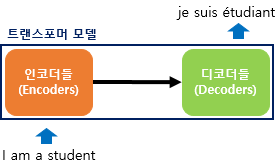

와 같은 인코더/디코더들을 자세하게 보면

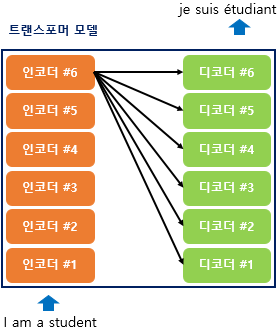

- 아래 그림은 인코더로부터 정보를 전달받아 디코더가 출력 결과를 만들어내는 트랜스포머 구조를 보여줌.
- 디코더는 마치 기존의 seq2seq 구조처럼 시작 심볼 $<sos>$를 입력으로 받아 종료 심볼 $<eos>$가 나올 때까지 연산을 진행.

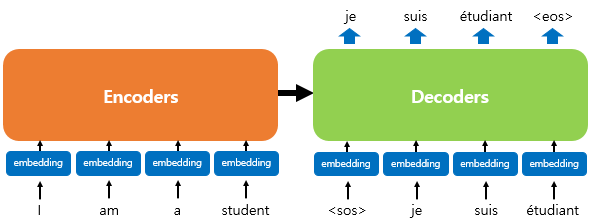


 - 순서
1.   입력
2.   어텐션
3.   인코더
4.   디코더
5.   Transformer




#1. 트랜스포머의 입력
- 트랜스포머의 인코더와 디코더는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받음. > 포지셔널 인코딩(Positional Encoding) 사용.
- RNN이 자연어 처리에서 유용했던 이유 : 단어를 순차적으로 입력받아 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점.
- 하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줘야함.
- 트랜스포머는 단어의 위치 정보를 얻기 위해서 **각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용**하는데, 이를 포지셔널 인코딩(positional encoding)이라 함.

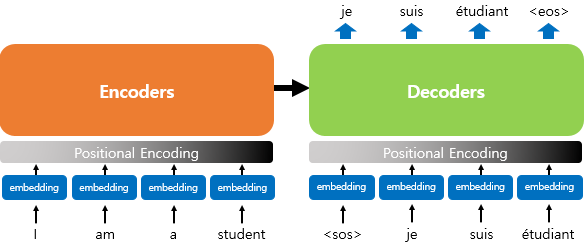

- 위의 그림은 입력으로 사용되는 임베딩 벡터들이 트랜스포머의 입력으로 사용되기 전 포지셔널 인코딩값이 더해지는 것을 보여줌.

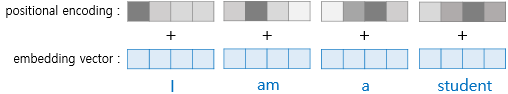

- 트랜스포머는 위치 정보를 가진 포지셔널 인코딩 값을 만들기 위해서 아래의 두 개의 함수를 사용.
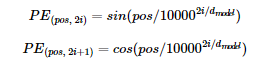

- 파란색 임베딩 벡터 > 문장 벡터 행렬
- 회색조 포지셔널 인코딩 행렬
- 두 행렬의 덧셈 연산으로 구성됨
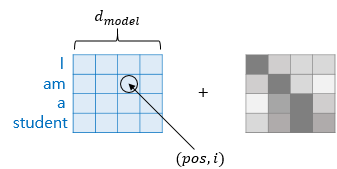

- pos : 입력 문장에서의 임베딩 벡터의 위치
- i : 는 임베딩 벡터 내의 차원의 인덱스
- 위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 홀수인 경우에는 코사인 함수의 값을 사용.
- 위의 수식에서 (pos, 2i) 일 때는 사인 함수를 사용, (pos, 2i + 1)일 때는 코사인 함수를 사용.
- d_model : 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터(논문 = 512)

- 각 임베딩 벡터에 포지셔널 인코딩값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라짐.
> 트랜스포머의 입력은 **순서 정보가 고려된 임베딩 벡터**

- 50 × 128의 크기를 가지는 포지셔널 인코딩 행렬을 시각화.(입력 문장의 단어 : 50개, 각 단어가 128차원의 임베딩 벡터를 가지는 행렬)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / torch.pow(10000.0, (2 * (i // 2)) / torch.tensor(d_model, dtype=torch.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=torch.arange(position, dtype=torch.float32).unsqueeze(1),
            i=torch.arange(d_model, dtype=torch.float32).unsqueeze(0),
            d_model=d_model)

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = torch.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = torch.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines.numpy()
        angle_rads[:, 1::2] = cosines.numpy()
        pos_encoding = torch.tensor(angle_rads)
        pos_encoding = pos_encoding.unsqueeze(0)

        print(pos_encoding.shape)
        return pos_encoding.float()

    def forward(self, inputs):
        return inputs + self.pos_encoding[:, :inputs.size(1), :]

In [ ]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 2. 어텐션(Attention)
- 트랜스포머에서 사용되는 세 가지 어텐션
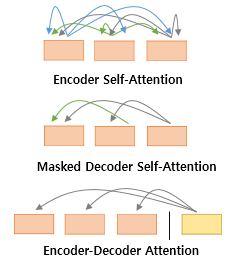
1.   Encoder Self-Attention(Encoder) : Query = Key = Value
2.   Masked Decoder Self-Attention(Decoder) : Query = Key = Value
3.   Encoder-Decoder Attention(Decoder) : Query : 디코더 벡터 / Key = Value : 인코더 벡터
- Self-Attention : 본질적으로 Query, Key, Value가 동일한 경우(주의 : Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다는 의미)
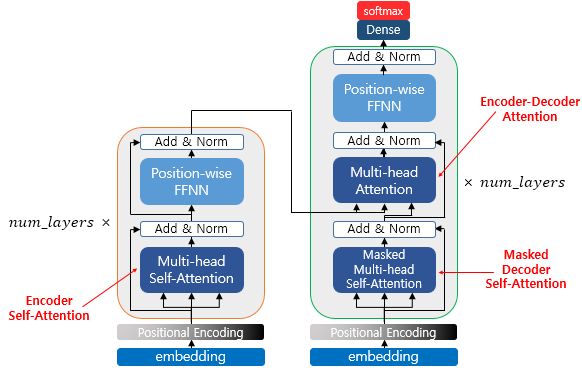
+ 멀티 헤드 :  트랜스포머가 어텐션을 병렬적으로 수행하는 방법을 의미


#3. 인코더(Encoder)
- 트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓음. (논문 : 총 6개의 인코더 층을 사용)
- 인코더를 하나의 층이라는 개념으로 생각한다면, 하나의 인코더 층은 크게 총 2개의 서브층(sublayer)으로 나눠짐.
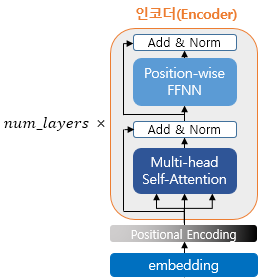
1.   (멀티 헤드) 셀프 어텐션 : 셀프 어텐션 병렬적으로 사용
2.   (포지션 와이즈) 피드 포워드 신경망 :

### <1. 인코더의 셀프 어텐션>
1) 셀프 어텐션의 의미와 이점

어텐션 함수
1.  주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 계산.
2.  구해낸 이 유사도를 가중치로 하여 키와 맵핑되어있는 각각의 '값(Value)'에 반영
3.  유사도가 반영된 '값(Value)'을 모두 가중합하여 리턴.


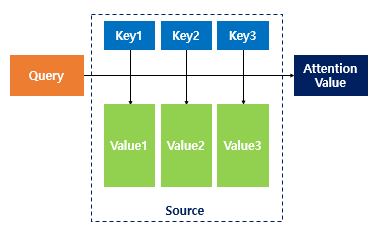
셀프어텐션 함수 : Q=K=V
- Q : 입력 문장의 모든 단어 벡터들
- K : 입력 문장의 모든 단어 벡터들
- V : 입력 문장의 모든 단어 벡터들

셀프어텐션의 효과 : 입력 문장 내의 단어들끼리 유사도를 구하므로서 그것(it)이 동물(animal)과 연관되었을 확률이 높다는 것을 찾음.
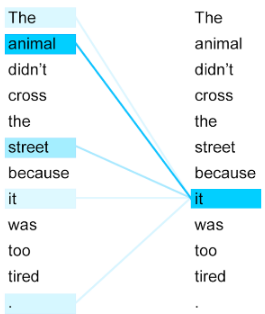

###<2. Q, K, V 벡터 얻기>
- 셀프 어텐션은 인코더의 초기 입력인 $d_{model}$ 의 차원을 가지는 단어 벡터들을 사용하여 셀프 어텐션을 수행하는 것이 아니라 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거침.
- 이 Q벡터, K벡터, V벡터들은 초기 입력인 $d_{model}$의 차원을 가지는 단어 벡터들보다 더 작은 차원을 가짐. (주의!)
- 논문에서는 $d_{model}$의 차원을 가졌던 각 단어 벡터들을 64의 차원을 가지는 Q벡터, K벡터, V벡터로 변환.
- 64 : 트랜스포머의 또 다른 하이퍼파라미터인 $num \_ heads$ 로 인해 결정. 트랜스포머는 $d_{model}$ 을 $num _heads 로 나눈 값을 각 Q벡터, K벡터, V벡터의 차원으로 결정. (논문 $num \_ heads$ = 8).

---  

- 예) 예문 중 student라는 단어 벡터를 Q, K, V의 벡터로 변환하는 과정
- 기존의 벡터로부터 더 작은 벡터는 가중치 행렬을 곱하므로서 완성.
- 각 가중치 행렬은 $d_{model} \times (d_{model}/num \_ heads)$의 크기. 이 가중치 행렬은 훈련 과정에서 학습.
- 즉, 논문과 같이 $d_{model}=512$이고 $num \_ heads=8$이면, 각 벡터에 3개의 서로 다른 가중치 행렬을 곱하고 64의 크기를 가지는 Q, K, V 벡터를 얻음.
- 모든 단어 벡터에 위와 같은 과정을 거치면 I, am, a, student는 각각의 Q, K, V 벡터를 얻음.
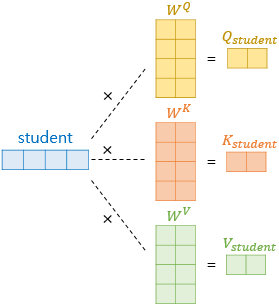

### <3. 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)>
- 각 Q 벡터는 모든 K 벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V 벡터를 가중합하여 어텐션 값 또는 컨텍스트 벡터를 구함. 그리고 이를 모든 Q 벡터에 대해서 반복.
- 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention) $score(q,k) = q \cdot k / \sqrt{n}$ 을 사용
- 단어 I에 대한 Q벡터를 기준으로 설명. am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 거침. 그림은 단어 I에 대한 Q 벡터가 모든 K 벡터에 대해서 어텐션 스코어를 구하는 것을 보여줌. 위의 128과 32는 저자가 임의로 가정한 수치.
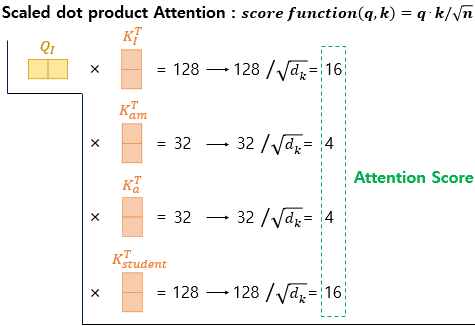

- 그림에서 어텐션 스코어는 각각 단어 I가 단어 I, am, a, student와 얼마나 연관되어 있는지를 보여주는 수치
- 트랜스포머에서는 두 벡터의 내적값을 스케일링하는 값으로 K 벡터의 차원에 루트를 씌운 $\sqrt{d_k}$를 사용하는 것을 택함
- ${d_k}$ 는 $d_{model}$ / $num \_ heads$ 에 따라 64의 값을 가지므로 $\sqrt{d_k}$는 8

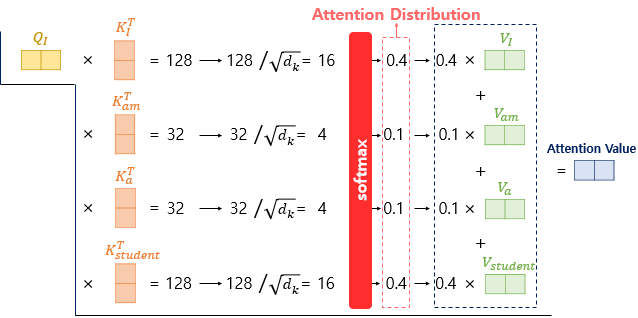

- 어텐션 스코어에 소프트맥스 함수를 사용하여 어텐션 분포(Attention Distribution)을 구하고, 각 V 벡터와 가중합하여 어텐션 값(Attention Value)을 구함.
- 이를 단어 I에 대한 어텐션 값 또는 단어 I에 대한 컨텍스트 벡터(context vector)라고도 부름.
- am에 대한 Q벡터, a에 대 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 반복하여 각각에 대한 어텐션 값을 구함.

### <4. 행렬 연산으로 일괄 처리하기>

- 실제로는 벡터 연산이 아닌 행렬 연산으로 구현됨
- 각 단어 벡터마다 일일히 가중치 행렬을 곱하는 것이 아니라 문장 행렬에 가중치 행렬을 곱하여 Q 행렬, K 행렬, V행렬을 구함.
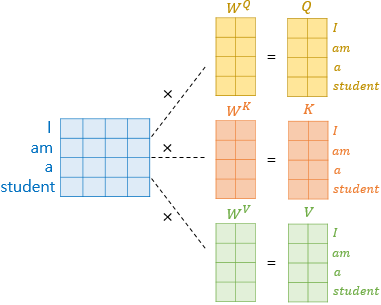
-  Q 행렬을 K 행렬을 전치한 행렬과 곱해주면 각각의 단어의 Q벡터와 K벡터의 내적이 각 행렬의 원소가 되는 행렬이 결과로 나옴.
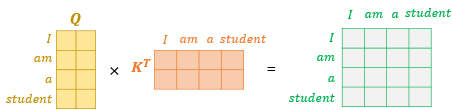

- 결과 행렬의 값에 전체적으로 $\sqrt{d_k}$ 를 나누어주면 이는 각 행과 열이 어텐션 스코어값을 가지는 행렬이 됨. > 어텐션 스코어 행렬
- 어텐션 분포를 구하고, 이를 사용하여 모든 단어에 대한 어텐션 값을 구하기 위해 어텐션 스코어 행렬에 소프트맥스 함수를 사용하고, V 행렬을 곱
- 각 단어의 어텐션 값을 모두 가지는 어텐션 값 행렬이 결과로 나옴

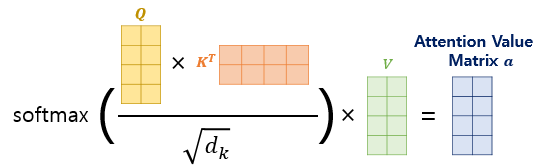
- 이는 논문의 수식과 일치함 $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}}) V$

- 입력 문장의 길이 : seq_len
- 문장 행렬의 크기 : (seq_len, $d_{model}$)
- 각 행에 해당되는 Q 벡터와 K 벡터의 크기 : $d_k$
- V 벡터의 크기 : $d_v$
- Q 행렬과 K 행렬의 크기 : (seq_len, $d_{k}$)
- V 행렬의 크기 : (seq_len, $d_{v}$)
- 가중치 행렬 $W^Q$, $W^K$의 크기 : ($d_{model}$, $d_{k}$)
- 가중치 행렬 $W^V$의 크기 : ($d_{model}$, $d_{v}$)
- $d_{k}$와 $d_{v}$의 크기 : $d_{model}$ / $num \_ heads$ = $d_{k}$ = $d_{v}$
- Attention 수식 결과 어텐션 값 행렬 $a$ 의 크기 : (seq_len, $d_{v}$)





In [ ]:
def scaled_dot_product_attention(query, key, value, mask=None):
    # query 크기: (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기: (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기: (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # mask: (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = query.size(-1)
    logits = matmul_qk / torch.sqrt(torch.tensor(depth).float())

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weights : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = F.softmax(logits, dim=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [ ]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
temp_k = torch.tensor([[10,0,0],
                       [0,10,0],
                       [0,0,10],
                       [0,0,10]], dtype=torch.float32)  # (4, 3)

temp_v = torch.tensor([[1,0],
                       [10,0],
                       [100,5],
                       [1000,6]], dtype=torch.float32)  # (4, 2)

temp_q = torch.tensor([[0, 10, 0]], dtype=torch.float32)  # (1, 3)

In [ ]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

In [ ]:
temp_q = torch.tensor([[0, 0, 10]], dtype=torch.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

### <5. 멀티 헤드 어텐션(Multi-head Attention)>
-  $num \_ heads $의 의미와 왜 $d_{model}$의 차원을 가진 단어 벡터를 가지고 어텐션을 하지 않고 차원을 축소시킨 벡터로 어텐션을 수행하였는지 이해 필요
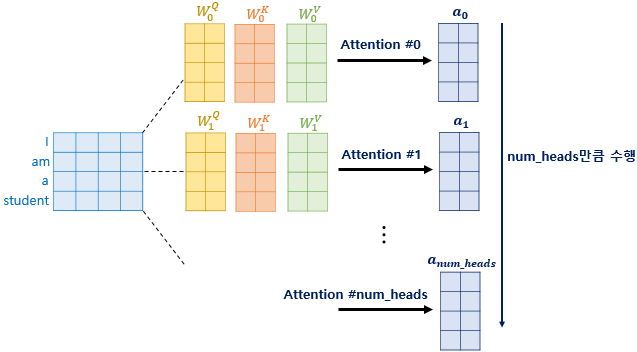
- 트랜스포머 연구진은 한 번의 어텐션을 하는 것보다 여러번의 어텐션을 병렬로 사용하는 것이 더 효과적이라고 판단.
- $d_{model}$ 의 차원을  $num \_ heads $ 개로 나누어  $d_{model} / num \_ heads $의 차원을 가지는 Q, K, V에 대해서 $num \_ heads $ 개의 병렬 어텐션을 수행.
- 논문에서는 하이퍼파라미터인 $num \_ heads $의 값을 8로 지정하였고, 8개의 병렬 어텐션이 이뤄짐. 이때 각각의 어텐션 값 행렬을 어텐션 헤드라고 부름.
- 이때 가중치 행렬 $W^Q, W^K, W^V $의 값은 8개의 어텐션 헤드마다 전부 다름.
- 어텐션을 병렬로 수행하여 다른 시각으로 정보들을 수집
---
예) '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.'
- 단어 그것(it)이 쿼리였다고 하면 it에 대한 Q벡터로부터 다른 단어와의 연관도를 구하였을 때 첫번째 어텐션 헤드는 '그것(it)'과 '동물(animal)'의 연관도를 높게 본다면, 두번째 어텐션 헤드는 '그것(it)'과 '피곤하였기 때문이다(tired)'의 연관도를 높게 볼 수 있음. 각 어텐션 헤드는 전부 다른 시각에서 보고있기 때문.
- 병렬 어텐션을 모두 수행하였다면 모든 어텐션 헤드를 연결(concatenate)
-  모두 연결된 어텐션 헤드 행렬의 크기 : (seq_len, $d_{model}$)
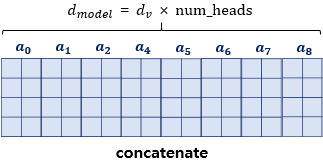
- 지금까지 그림에서는 지면상의 한계로 4차원을 $d_{model}$=512로 표현하고, 2차원을 $d_{v}$=64로 표현해왔기 때문에 위의 그림의 행렬의 크기에 혼동의 있을 수 있으나 8개의 어텐션 헤드의 연결(concatenate) 과정의 이해를 위해 이번 행렬만 예외로 위와 같이 $d_{model}$의 크기를 $d_{v}$의 8배인 16차원으로 표현. 아래의 그림에서는 다시 $d_{model}$를 4차원으로 표현.
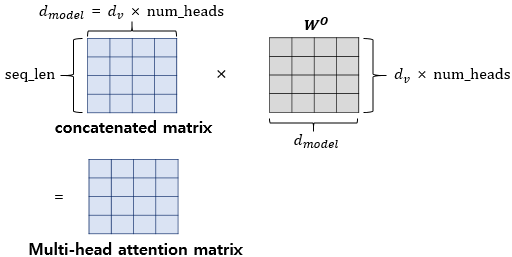
- 어텐션 헤드를 모두 연결한 행렬은 또 다른 가중치 행렬 $W^o$을 곱하게 되는데, 이렇게 나온 결과 행렬이 멀티-헤드 어텐션의 최종 결과물.
- 위의 그림은 어텐션 헤드를 모두 연결한 행렬이 가중치 행렬 $W^o$과 곱해지는 과정을 보여줌.
- 이때 결과물인 멀티-헤드 어텐션 행렬은 인코더의 입력이었던 문장 행렬의 크기와 동일.
- 인코더의 첫번째 서브층인 멀티-헤드 어텐션 단계를 끝마쳤을 때, 인코더의 입력으로 들어왔던 행렬의 크기가 아직 유지되고 있음을 기억.
- 첫번째 서브층인 멀티-헤드 어텐션과 두번째 서브층인 포지션 와이즈 피드 포워드 신경망을 지나면서 인코더의 입력으로 들어올 때의 행렬의 크기는 계속 유지되어야 함.
- 트랜스포머는 다수의 인코더를 쌓은 형태인데(논문에서는 인코더가 6개), 인코더에서의 입력의 크기가 출력에서도 동일 크기로 계속 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있기 때문.


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0, "d_model must be divisible by num_heads"

        self.depth = d_model // self.num_heads

        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, value, mask):
        batch_size = query.shape[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3)

        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)

        outputs = self.dense(concat_attention)

        return outputs


### <6. 패딩 마스크(Padding Mask)>
-  스케일드 닷 프로덕트 어텐션 함수 내부를 보면 mask라는 값을 인자로 받아서, 이 mask값에다가 -1e9라는 아주 작은 음수값을 곱한 후 어텐션 스코어 행렬에 더해줌
- 이는 입력 문장에 <PAD> 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산.

---
예) <PAD>가 포함된 입력 문장의 셀프 어텐션의 예제를 보면, 어텐션을 수행하고 어텐션 스코어 행렬을 얻는 과정은 다음과 같음.
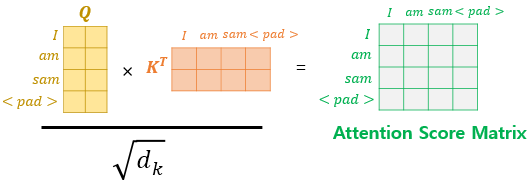

- 그런데 <PAD>의 경우에는 실질적인 의미를 가진 단어가 아님. 그래서 트랜스포머에서는 Key의 경우에 <PAD> 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않도록 마스킹(Masking) (: 어텐션에서 제외하기 위해 값을 가린다는 의미)을 해주기로 함.

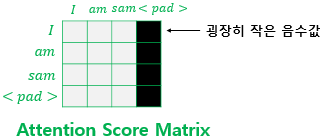

- 어텐션 스코어 행렬에서 행에 해당하는 문장은 Query이고, 열에 해당하는 문장은 Key. 그리고 Key에 <PAD>가 있는 경우에는 해당 열 전체를 마스킹을 해줌.
- 마스킹을 하는 방법은 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣어주는 것.
- 여기서 매우 작은 음수값이라는 것은 -1,000,000,000과 같은 -무한대에 가까운 수. 어텐션 스코어 함수는 소프트맥스 함수를 지나지 않은 상태.
- 앞서 배운 연산 순서라면 어텐션 스코어 함수는 소프트맥스 함수를 지나고, 그 후 Value 행렬과 곱해지게 됨.
- 그런데 현재 마스킹 위치에 매우 작은 음수 값이 들어가 있으므로 어텐션 스코어 행렬이 소프트맥스 함수를 지난 후에는 해당 위치의 값은 0에 굉장히 가까운 값이 되어 단어 간 유사도를 구하는 일에 <PAD> 토큰이 반영되지 않게 됨.

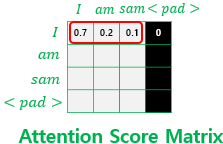

- 위 그림은 소프트맥스 함수를 지난 후를 가정하고 있음. 소프트맥스 함수를 지나면 각 행의 어텐션 가중치의 총 합은 1이 되는데, 단어 <PAD>의 경우에는 0이 되어 어떤 유의미한 값을 가지고 있지 않음.

In [ ]:
def create_padding_mask(x):
    mask = torch.eq(x, 0).float()
    # (batch_size, 1, 1, key의 문장 길이)
    return mask.unsqueeze(1).unsqueeze(2)

# 예제 실행
x = torch.tensor([[1, 21, 777, 0, 0]])
mask = create_padding_mask(x) #  1의 값을 가진 위치의 열을 어텐션 스코어 행렬에서 마스킹하는 용도로 사용 가능
print(mask)
# [[1, 21, 777, 0, 0]] 벡터를 스케일드 닷 프로덕트 어텐션의 인자로 전달하면, 스케일드 닷 프로덕트 어텐션에서는 위 벡터에다가 매우 작은 음수값인 -1e9를 곱하고, 이를 행렬에 더해주어 해당 열을 전부 마스킹(1)

### <7. 포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)>
- 지금은 인코더를 설명하고 있지만, 포지션 와이즈 FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 서브층입니다. 포지션-와이즈 FFNN는 쉽게 말하면 완전 연결 FFNN(Fully-connected FFNN)이라고 해석할 수 있습니다. 앞서 인공 신경망은 결국 벡터와 행렬 연산으로 표현될 수 있음을 배웠습니다. 포지션 와이즈 FFNN의 수식 : $FFNN(x) = Max(0, x W_1 + b_1) W_2 + b_2$
- $x$ : 멀티 헤드 어텐션의 결과로 나온 (seq_len, $d_{model}$)의 크기를 가지는 행렬.
- 가중치 행렬 $W_1$ : ($d_{model}$, $d_{ff}$) 의 크기를 가지고, 가중치 행렬 $W_2$ 은 ($d_{ff}$, $d_{model}$)의 크기를 가짐.
- 논문에서 은닉층의 크기인 $d_{ff}$ = 2,048 (하이퍼파라미터)
- 매개변수 $W_1, b_1, W_2, b_2$ 는 하나의 인코더 층 내에서는 다른 문장, 다른 단어들마다 정확하게 동일하게 사용하지만 인코더 층마다는 다른 값을 가짐.
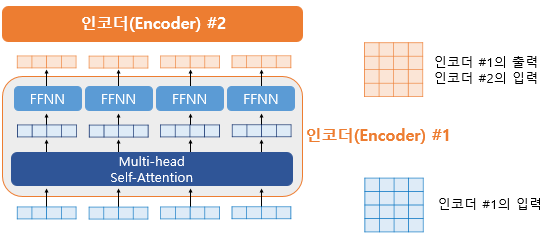
- 위의 그림에서 좌측은 인코더의 입력을 벡터 단위로 봤을 때, 각 벡터들이 멀티 헤드 어텐션 층이라는 인코더 내 첫번째 서브 층을 지나 FFNN을 통과하는 것을 보여줌.
- 이는 두번째 서브층인 Position-wise FFNN을 의미.
- 실제로는 그림의 우측과 같이 행렬로 연산되는데, 두번째 서브층을 지난 인코더의 최종 출력은 여전히 인코더의 입력의 크기였던 (seq_len, $d_{model}$) 의 크기가 보존.
- 하나의 인코더 층을 지난 이 행렬은 다음 인코더 층으로 전달되고, 다음 층에서도 동일한 인코더 연산이 반복.



### <8. 잔차 연결(Residual connection)과 층 정규화(Layer Normalization)>

- 트랜스포머에서는 두 개의 서브층을 가진 인코더에 추가적으로 사용하는 기법으로 Add(잔차 연결(residual connection)) & Norm( 층 정규화(layer normalization)).

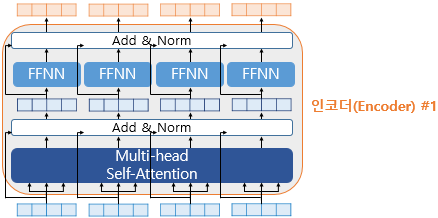
- 위의 그림은 앞서 Position-wise FFNN를 설명할 때 사용한 앞선 그림에서 화살표와 Add & Norm(잔차 연결과 정규화 과정)을 추가한 그림.
- 추가된 화살표들은 서브층 이전의 입력에서 시작되어 서브층의 출력 부분을 향하고 있는 것에 주목.

1) 잔차 연결(Residual connection)
- 잔차 연결(residual connection) 함수 $H(x)$
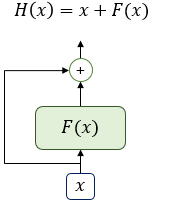

- 위 그림은 입력 $x$와 $x$에 대한 어떤 함수 $H(x)$의 값을 더한 함수 $F(x)$의 구조를 보여줌.
- 어떤 함수 $F(x)$가 트랜스포머에서는 서브층에 해당.
- 트랜스포머에서 서브층의 입력과 출력은 동일한 차원을 갖고 있으므로, 서브층의 입력과 서브층의 출력은 덧셈 연산을 할 수 있음.
- 이를 식으로 표현하면 $x + Sublayer(x)$
- 가령, 서브층이 멀티 헤드 어텐션이었다면 잔차 연결 연산은 다음과 같음
$H(x) = x + Multi - head Attention(x) $

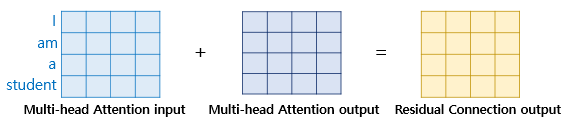

- 위 그림은 멀티 헤드 어텐션의 입력과 멀티 헤드 어텐션의 결과가 더해지는 과정을 보여줌.

2) 층 정규화(Layer Normalization)
- 잔차 연결을 거친 결과는 이어서 층 정규화 과정을 거침.
- 잔차 연결의 입력을 $x$, 잔차 연결과 층 정규화 두 가지 연산을 모두 수행한 후의 결과 행렬을 LN이라고 하였을 때, 잔차 연결 후 층 정규화 연산을 수식으로 표현하자면 다음과 같음.
$LN = LayerNorm(x + sublater(x))$
- 층 정규화는 텐서의 마지막 차원에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화. 여기서 텐서의 마지막 차원이란 것은 트랜스포머에서는 $d_{model}$ 차원.
- 아래 그림은 $d_{model}$차원의 방향을 화살표로 표현.
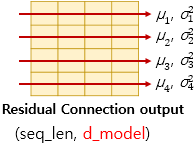

- 층 정규화를 위해 화살표 방향으로 각각 평균 $\mu$과 분산 $σ^2$
을 구함. 각 화살표 방향의 벡터를 $x_i$라고 명명.
- 층 정규화를 수행한 후에는 벡터 $x_i$는 $ln_{i}$라는 벡터로 정규화
$ln_{i} = LayerNorm(x_i)$
- 수식 :
1) 평균과 분산을 통한 정규화 : 평균과 분산을 통해 벡터 $x_i$정규화
- $x_i$는 벡터, 평균 $\mu_i$ 분산 $σ^2$은 스칼라.
$\hat{x}_{i,j} = \frac{x_{i,k} - \mu_i }{\sqrt{\sigma^2_i + ϵ}}$
ϵ : 분모가 0되는 것을 방지하는 값  
2) 감마와 베타를 도입
-  이들의 초기값은 각각 1과 0.
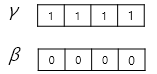
- 학습 가능한 파라미터
수식 : $ln_i = \gamma \hat{x}_i + \beta  = LayerNorm(x_i)$

### <9. 인코더 구현하기>
- 인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용. (MultiHeadAttention 함수의 mask의 인자값으로 padding_mask가 들어가는 이유)
- 인코더는 총 두 개의 서브층으로 구성
1) 멀티 헤드 어텐션 2) 피드 포워드 신경망.
- 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화 수행.
- 위 코드는 하나의 인코더 블록. 즉, 하나의 인코더 층을 구현하는 코드.
- 실제로 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현해줄 필요가 있음.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, dff, d_model, num_heads, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        self.dense1 = nn.Linear(d_model, dff)
        self.dense2 = nn.Linear(dff, d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, padding_mask):
        attn_output = self.multi_head_attention(x, x, x, padding_mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)

        ffn_output = F.relu(self.dense1(out1))
        ffn_output = self.dense2(ffn_output)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)

        return out2


###<10. 인코더 쌓기>

- 지금까지 인코더 층의 내부 아키텍처에 대해서 이해.
- 이러한 인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보내주므로서 트랜스포머 인코더의 인코딩 연산이 끝나게 됩니다. 아래의 코드는 인코더 층을 num_layers개만큼 쌓는 코드입니다.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_layers, dff, d_model, num_heads, dropout):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(vocab_size, d_model)
        self.enc_layers = nn.ModuleList([EncoderLayer(dff, d_model, num_heads, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, padding_mask):
        seq_len = x.shape[1]

        # Adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, padding_mask)

        return x  # (batch_size, input_seq_len, d_model)


### <11. 인코더에서 디코더로(From Encoder To Decoder)>
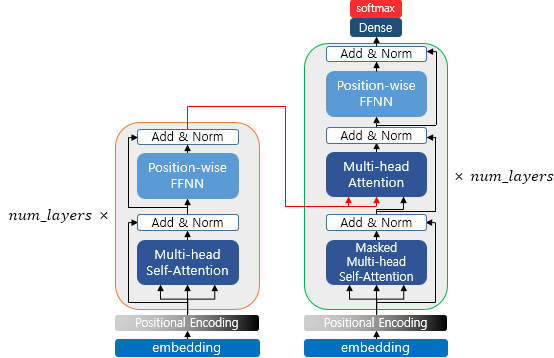

- 이렇게 구현된 인코더는 총 $num \_ heads $만큼의 층 연산을 순차적으로 한 후에 마지막 층의 인코더의 출력을 디코더에게 전달.
- 인코더 연산이 끝났으므로 이제 디코더 연산이 시작되어 디코더 또한 총 만큼의 연산을 하는데, 이때마다 인코더가 보낸 출력을 각 디코더 층 연산에 사용.

# 4. 디코더

### <1. 디코더의 첫번째 서브층 : 셀프 어텐션과 룩-어헤드 마스크>

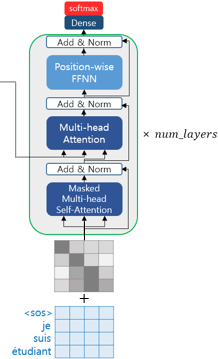

- 위 그림과 같이 디코더도 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력.
- 트랜스포머 또한 seq2seq와 마찬가지로 교사 강요(Teacher Forcing)을 사용하여 훈련되므로 학습 과정에서 디코더는 번역할 문장에 해당되는 <sos> je suis étudiant의 문장 행렬을 한 번에 입력받음.
- 디코더는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련.

- 문제 : seq2seq의 디코더에 사용되는 RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 받으므로 다음 단어 예측에 현재 시점 이전 이전에 입력된 단어들만 참고할 수 있음. 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생.

- 이를 위해 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩-어헤드 마스크(look-ahead mask)를 도입.
- 룩-어헤드 마스크(look-ahead mask) : 디코더의 첫번째 서브층에서 이뤄짐. 디코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층은 인코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층과 동일한 연산을 수행.
- 오직, 다른 점은 어텐션 스코어 행렬에서 마스킹을 적용한다는 점.


1.   셀프 어텐션을 통해 어텐션 스코어 행렬 계산
2.   자기 자신보다 미래에 있는 단어들은 참고하지 못하도록 마스킹


- 마스킹 된 후의 어텐션 스코어 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음. 그 외에는 근본적으로 셀프 어텐션이라는 점과, 멀티 헤드 어텐션을 수행한다는 점에서 인코더의 첫번째 서브층과 같음.
- 룩-어헤드 마스크에도 패딩 마스크를 포함하도록 구현
- 마스킹을 하고자 하는 위치에는 1을, 마스킹을 하지 않는 위치에는 0을 리턴.


In [ ]:
def create_look_ahead_mask(x):
    seq_len = x.shape[1]
    look_ahead_mask = torch.ones(seq_len, seq_len).triu(diagonal=1)  # 대각선 위의 값을 1로 채움
    padding_mask = create_padding_mask(x)  # 앞서 정의한 패딩 마스크 함수 사용

    # 룩어헤드 마스크와 패딩 마스크의 최댓값을 취함
    # 룩어헤드 마스크와 패딩 마스크는 (batch_size, 1, seq_len, seq_len) 형태로 확장 필요
    look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(0)
    max_mask = torch.max(look_ahead_mask, padding_mask)
    return max_mask

# 예제 실행
x = torch.tensor([[1, 2, 3, 0, 0]])
mask = create_look_ahead_mask(x)
print(mask) #룩어헤드 마스크(look-ahead mask)와 패딩 마스크(padding mask)를 결합한 결과

### <2. 디코더의 두번째 서브층 : 인코더-디코더 어텐션>
- 디코더의 두번째 서브층은 멀티 헤드 어텐션을 수행한다는 점에서는 이전의 어텐션들(인코더와 디코더의 첫번째 서브층)과 같지만, 셀프 어텐션은 아님.
- 셀프 어텐션은 Query, Key, Value가 같은 경우를 말하는데, 인코더-디코더 어텐션은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문.
- 다시 한 번 각 서브층에서의 Q, K, V의 관계를 정리


> - 인코더의 첫번째 서브층 : Query = Key = Value
> - 디코더의 첫번째 서브층 : Query = Key = Value
> - 디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬

- 디코더의 두번째 서브층을 확대해보면, 인코더로부터 두 개의 화살표가 그려져 있음

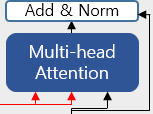

- 두 개의 화살표는 각각 Key와 Value를 의미하며, 이는 인코더의 마지막 층에서 온 행렬로부터 얻음.
- 반면, Query는 디코더의 첫번째 서브층의 결과 행렬로부터 얻는다는 점이 다름.
- Query가 디코더 행렬, Key가 인코더 행렬일 때, 어텐션 스코어 행렬을 구하는 과정
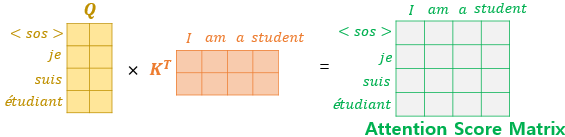


### <3. 디코더 구현하기>


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, dff, d_model, num_heads, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
        )

        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm3 = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        # 셀프 어텐션과 레이어 정규화
        attn1, _ = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        # 디코더-인코더 어텐션과 레이어 정규화
        attn2, _ = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)

        # 피드 포워드 네트워크와 레이어 정규화
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)

        return out3


- 디코더는 총 세 개의 서브층으로 구성.
1) 멀티 헤드 어텐션 : mask의 인자값으로 look_ahead_mask가 들어감
2) 멀티 헤드 어텐션 : mask의 인자값으로 padding_mask가 들어감
- 이는 첫번째 서브층은 마스크드 셀프 어텐션을 수행하기 때문.
- 세 개의 서브층 모두 서브층 연산 후에는 드롭 아웃, 잔차 연결, 층 정규화가 수행되는 것을 확인할 수 있음.

- 인코더와 마찬가지로 디코더도 num_layers개만큼 쌓는 코드가 필요

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, num_layers, dff, d_model, num_heads, dropout):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(vocab_size, d_model)

        self.dec_layers = nn.ModuleList([
            DecoderLayer(dff, d_model, num_heads, dropout) for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.size(1)

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

        return x  # (batch_size, target_seq_len, d_model)


# 5. 트랜스포머 구현하기

- 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립.
- 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달해줌.
- 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 신경망을 추가.

In [ ]:
'''

Transformer 클래스를 완성하시오.
해당 클래스는 encoder, decoder를 각각 1 block 씩 갖습니다.

def __init__():
    #매개변수
    vocab_size: 어휘 사전의 크기. 입력 및 출력 언어에 대한 어휘의 크기를 지정합니다.
    num_layers: 인코더 및 디코더 스택 내의 층(layer)의 수입니다.
    dff: 피드포워드 네트워크 내의 은닉층의 차원입니다.
    d_model: 인코더와 디코더의 입력 및 출력에서의 차원 수입니다.
    num_heads: 멀티 헤드 어텐션에서의 헤드(head) 수입니다.
    dropout: 드롭아웃 비율로, 모델을 학습할 때 무작위로 입력의 일부를 0으로 설정하여 과적합을 방지하는 데 사용됩니다.

    #아래 Transformer 클래스는 구성요소를 갖습니다.
    encoder: 입력 데이터를 변환하기 위한 인코더 객체입니다. 여기서 Encoder 클래스의 인스턴스가 생성됩니다.
    decoder: 인코더의 출력을 바탕으로 출력 데이터를 생성하기 위한 디코더 객체입니다. 여기서 Decoder 클래스의 인스턴스가 생성됩니다.
    final_layer: 디코더의 출력을 최종 어휘 사전의 크기에 맞는 출력으로 변환하는 선형 계층입니다. 이는 nn.Linear를 사용하여 구현됩니다.

def forward():
    #매개변수
    입력 데이터(inp) : 모델에 입력되는 데이터
    인코딩 패딩 마스크(enc_padding_mask) : : 인코더에서 입력 데이터를 처리할 때, 패딩된 부분을 신경망이 무시하도록 하는 마스크

    타겟 데이터(tar) : 모델이 예측하려고 하는 대상 데이터
    룩어헤드 마스크(look_ahead_mask) : 디코더가 아직 예측하지 않은 미래의 단어를 "보지 못하게" 하는 마스크
    디코딩 패딩 마스크(dec_padding_mask) : 디코더에서 타겟 데이터의 패딩된 부분을 신경망이 무시하도록 하는 마스크

    #Transformer의 구성요소를 적절히 연결해줘야 합니다.

'''

# Transformer를 완성시키시오.
class Transformer(nn.Module):
    def __init__():


    def forward():






### <1. 트랜스포머 하이퍼파라미터 정하기>
- 이제 트랜스포머의 하이퍼파라미터를 임의로 정하고, 모델을 만들어봅시다.
- 단어 집합의 크기 : 임의로 9,000
- 단어 집합의 크기로부터 룩업 테이블을 수행할 임베딩 테이블과 포지셔널 인코딩 행렬의 행의 크기를 결정할 수 있음.


In [ ]:
small_transformer = Transformer(
    vocab_size=9000,
    num_layers=4,
    dff=512,
    d_model=128,
    num_heads=4,
    dropout=0.3
)

small_transformer

### <2. 손실 함수 정의하기>
- 다중 클래스 분류 문제를 풀 예정이므로 크로스 엔트로피 함수를 손실 함수로 정의.



In [ ]:
def loss_function(y_true, y_pred, pad_token=0):
    # y_true의 shape을 조정하지 않아도 되며, PyTorch CrossEntropyLoss가 처리합니다.
    # y_pred: (batch_size, seq_len, vocab_size), y_true: (batch_size, seq_len)

    # CrossEntropyLoss는 target이 (N, ) 형태이고 입력이 (N, C)인 경우 자동으로 평탄화(flatten)을 수행합니다.
    # 여기서 N은 배치 크기 * 시퀀스 길이, C는 클래스 수(어휘 크기)입니다.
    # 그러나 여기서는 시퀀스 길이를 직접 관리하므로, 수동으로 평탄화하지 않고,
    # 대신 mask를 적용하여 패딩 토큰을 제외합니다.

    loss_obj = torch.nn.CrossEntropyLoss(reduction='none')  # 각 요소별로 손실 계산
    loss = loss_obj(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1))

    mask = (y_true != pad_token).float()  # 패딩이 아닌 위치는 1, 패딩 위치는 0인 마스크
    loss = loss * mask.view(-1)  # 마스크 적용

    # 마스크를 적용한 후 평균 손실을 계산
    loss = torch.sum(loss) / torch.sum(mask)

    return loss
